In [29]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [31]:
file_path = r"C:\Users\prath\Downloads\StudentsPerformance.csv"
df = pd.read_csv(file_path)

In [32]:
df_encoded = pd.get_dummies(df, columns=[
    'gender', 
    'race/ethnicity', 
    'parental level of education', 
    'lunch', 
    'test preparation course'
])

In [33]:
X_reg = df_encoded.drop(['math score', 'reading score', 'writing score'], axis=1)
y_reg = df_encoded[['math score', 'reading score', 'writing score']]  # Keep scores as DataFrame

In [34]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [35]:
y_class = (df['math score'] < 50).astype(int)

In [36]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_reg, y_class, test_size=0.2, stratify=y_class, random_state=42
)


In [37]:
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(df_encoded)

In [38]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, silhouette_score

In [39]:
math_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
reading_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
writing_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [40]:
math_model.fit(X_train_reg, y_train_reg['math score'])
reading_model.fit(X_train_reg, y_train_reg['reading score'])
writing_model.fit(X_train_reg, y_train_reg['writing score'])

GradientBoostingRegressor(random_state=42)

In [41]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
clf.fit(X_train_clf, y_train_clf)

GradientBoostingClassifier(random_state=42)

In [42]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_cluster_scaled)
df['cluster'] = kmeans.labels_  # Add cluster labels to original data

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_regression(model, X_test, y_true, subject):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_true, y_pred)  # Compute MSE
    rmse = mse ** 0.5  # Manually take the square root for RMSE
    r2 = r2_score(y_true, y_pred)
    print(f"{subject} Scores - RMSE: {rmse:.2f}, R²: {r2:.2f}")

evaluate_regression(math_model, X_test_reg, y_test_reg['math score'], "Math")
evaluate_regression(reading_model, X_test_reg, y_test_reg['reading score'], "Reading")
evaluate_regression(writing_model, X_test_reg, y_test_reg['writing score'], "Writing")

Math Scores - RMSE: 14.70, R²: 0.11
Reading Scores - RMSE: 14.33, R²: 0.09
Writing Scores - RMSE: 13.91, R²: 0.20


In [45]:
y_pred_clf = clf.predict(X_test_clf)
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.2f}")
print(f"Precision: {precision_score(y_test_clf, y_pred_clf):.2f}")
print(f"Recall: {recall_score(y_test_clf, y_pred_clf):.2f}")
print(f"F1-Score: {f1_score(y_test_clf, y_pred_clf):.2f}")


Classification Metrics:
Accuracy: 0.88
Precision: 0.71
Recall: 0.19
F1-Score: 0.29


In [46]:
silhouette = silhouette_score(X_cluster_scaled, kmeans.labels_)
print(f"\nClustering Silhouette Score: {silhouette:.2f}")



Clustering Silhouette Score: 0.10


In [47]:
print("\nCluster Profiles (Mean Scores):")
print(df.groupby('cluster')[['math score', 'reading score', 'writing score']].mean())


Cluster Profiles (Mean Scores):
         math score  reading score  writing score
cluster                                          
0         67.521008      74.697479      74.226891
1         69.449074      64.333333      61.523148
2         73.579125      77.811448      78.346801
3         52.871486      57.771084      55.542169


In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
# Example: Tune the classifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_clf, y_train_clf)
print(f"\nBest Classifier Parameters: {grid_search.best_params_}")


Best Classifier Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}


In [50]:
# 8. Ethical Checks (Bias Audit)
# ======================
# Compare precision/recall across subgroups (e.g., gender)
subgroups = df['gender'].iloc[y_test_clf.index]  # Align with test set
from sklearn.metrics import classification_report
print("\nPerformance by Gender:")
print(classification_report(y_test_clf, y_pred_clf, target_names=['Not At-Risk', 'At-Risk'], labels=[0, 1]))


Performance by Gender:
              precision    recall  f1-score   support

 Not At-Risk       0.89      0.99      0.93       173
     At-Risk       0.71      0.19      0.29        27

    accuracy                           0.88       200
   macro avg       0.80      0.59      0.61       200
weighted avg       0.86      0.88      0.85       200



In [52]:
results = {
    "Regression": {
        "Math RMSE": mean_squared_error(y_test_reg['math score'], math_model.predict(X_test_reg)) ** 0.5,
        "Math R²": r2_score(y_test_reg['math score'], math_model.predict(X_test_reg)),
        "Reading RMSE": mean_squared_error(y_test_reg['reading score'], reading_model.predict(X_test_reg)) ** 0.5,
        "Reading R²": r2_score(y_test_reg['reading score'], reading_model.predict(X_test_reg)),
        "Writing RMSE": mean_squared_error(y_test_reg['writing score'], writing_model.predict(X_test_reg)) ** 0.5,
        "Writing R²": r2_score(y_test_reg['writing score'], writing_model.predict(X_test_reg))
    },
    "Classification": {
        "Accuracy": accuracy_score(y_test_clf, y_pred_clf),
        "F1-Score": f1_score(y_test_clf, y_pred_clf)
    },
    "Clustering": {
        "Silhouette Score": silhouette
    }
}

# Save results to DataFrame
results_df = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df)


Final Results:
                  Regression  Classification  Clustering
Math RMSE          14.697160             NaN         NaN
Math R²             0.112320             NaN         NaN
Reading RMSE       14.331672             NaN         NaN
Reading R²          0.092307             NaN         NaN
Writing RMSE       13.906508             NaN         NaN
Writing R²          0.197604             NaN         NaN
Accuracy                 NaN        0.880000         NaN
F1-Score                 NaN        0.294118         NaN
Silhouette Score         NaN             NaN    0.099702


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (mean_squared_error, r2_score, 
                           accuracy_score, precision_score, 
                           recall_score, f1_score, silhouette_score,
                           confusion_matrix)
from sklearn.decomposition import PCA
import numpy as np

In [55]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [56]:
file_path = r"C:\Users\prath\Downloads\StudentsPerformance.csv"
df = pd.read_csv(file_path)

In [57]:
print("Data Overview:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

Data Overview:
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  

Missing Values:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                       

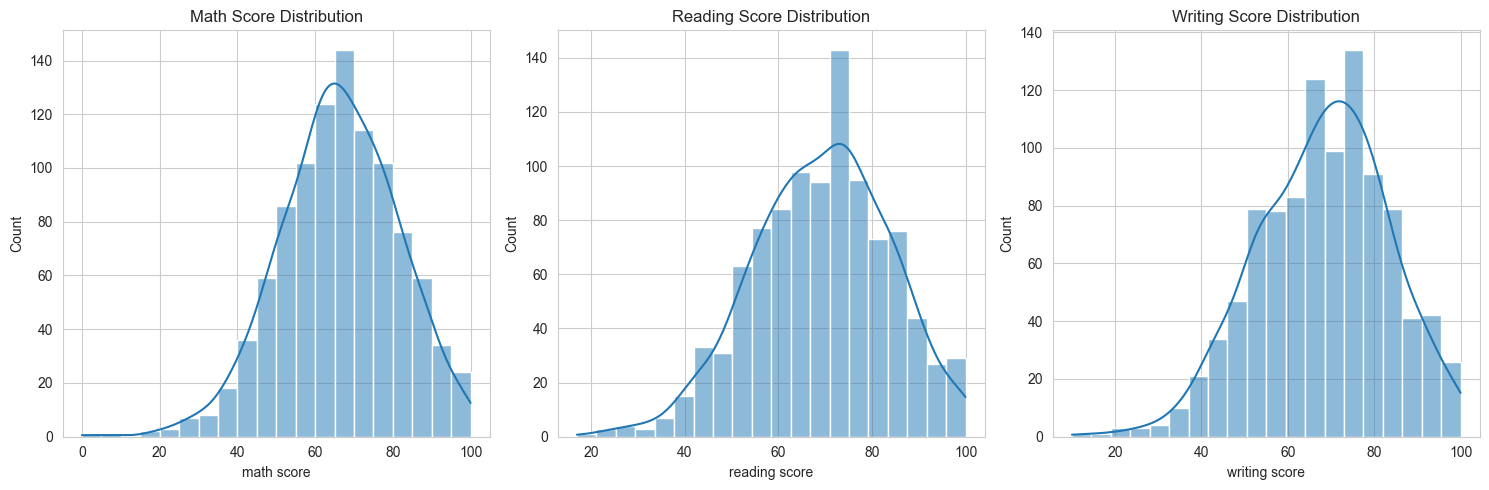

In [58]:
plt.figure(figsize=(15, 5))
for i, subject in enumerate(['math score', 'reading score', 'writing score']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[subject], kde=True, bins=20)
    plt.title(f'{subject.title()} Distribution')
plt.tight_layout()
plt.savefig('score_distributions.png')
plt.show()

In [59]:
df_encoded = pd.get_dummies(df, columns=['gender', 'race/ethnicity', 
                                        'parental level of education', 
                                        'lunch', 'test preparation course'])


In [60]:
X = df_encoded.drop(['math score', 'reading score', 'writing score'], axis=1)
y_scores = df_encoded[['math score', 'reading score', 'writing score']]
y_class = (df['math score'] < 50).astype(int)  # At-risk if math score < 50

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scores, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [63]:
print("\nTraining Score Prediction Models...")
models = {}
for subject in ['math', 'reading', 'writing']:
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train[f'{subject} score'])
    models[subject] = model
    pred = model.predict(X_test)
    
    # Compute RMSE manually
    mse = mean_squared_error(y_test[f'{subject} score'], pred)
    rmse = mse ** 0.5  # Taking square root manually

    print(f"{subject.title()} Scores - RMSE: {rmse:.2f}, R²: {r2_score(y_test[f'{subject} score'], pred):.2f}")


Training Score Prediction Models...
Math Scores - RMSE: 14.70, R²: 0.11
Reading Scores - RMSE: 14.33, R²: 0.09
Writing Scores - RMSE: 13.91, R²: 0.20


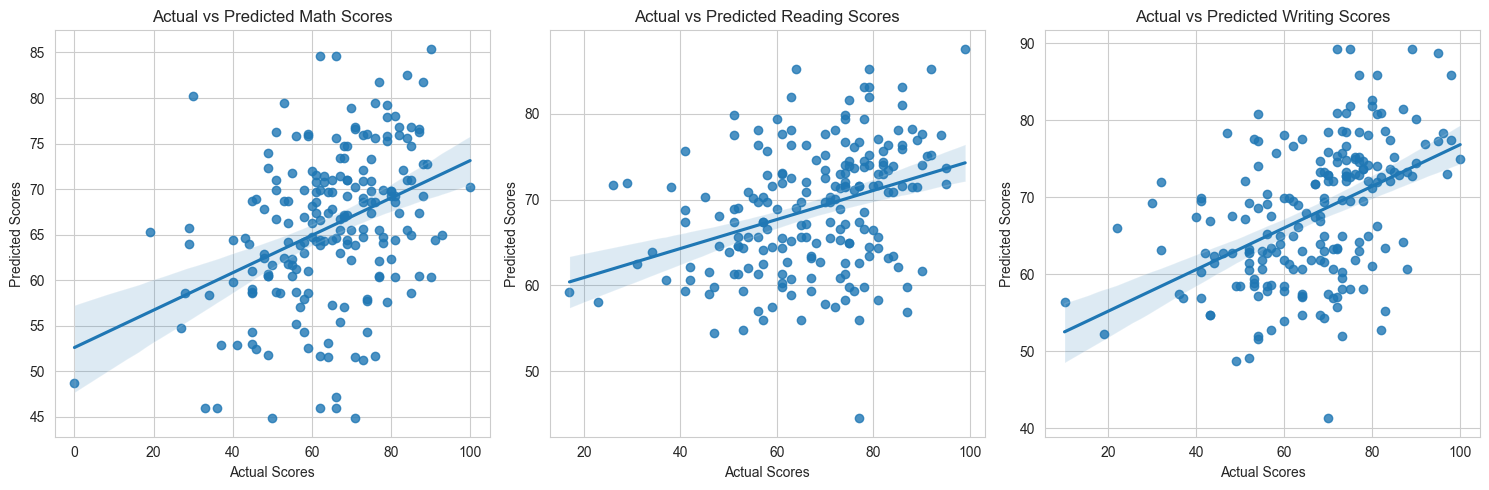

In [64]:
plt.figure(figsize=(15, 5))
for i, subject in enumerate(['math', 'reading', 'writing']):
    plt.subplot(1, 3, i+1)
    sns.regplot(x=y_test[f'{subject} score'], y=models[subject].predict(X_test))
    plt.title(f'Actual vs Predicted {subject.title()} Scores')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
plt.tight_layout()
plt.savefig('regression_results.png')
plt.show()

In [65]:
print("\nTraining At-Risk Classifier...")
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
clf.fit(X_train_clf, y_train_clf)
y_pred = clf.predict(X_test_clf)


Training At-Risk Classifier...


In [66]:
print("\nClassification Report:")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred):.2f}")
print(f"Precision: {precision_score(y_test_clf, y_pred):.2f}")
print(f"Recall: {recall_score(y_test_clf, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test_clf, y_pred):.2f}")


Classification Report:
Accuracy: 0.83
Precision: 0.50
Recall: 0.06
F1-Score: 0.11


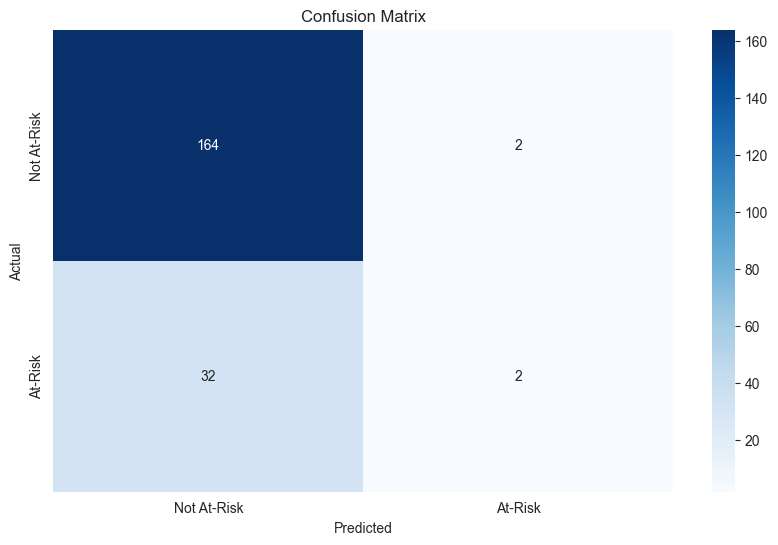

In [67]:
cm = confusion_matrix(y_test_clf, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not At-Risk', 'At-Risk'],
            yticklabels=['Not At-Risk', 'At-Risk'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

In [68]:
print("\nPerforming Clustering...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)



Performing Clustering...


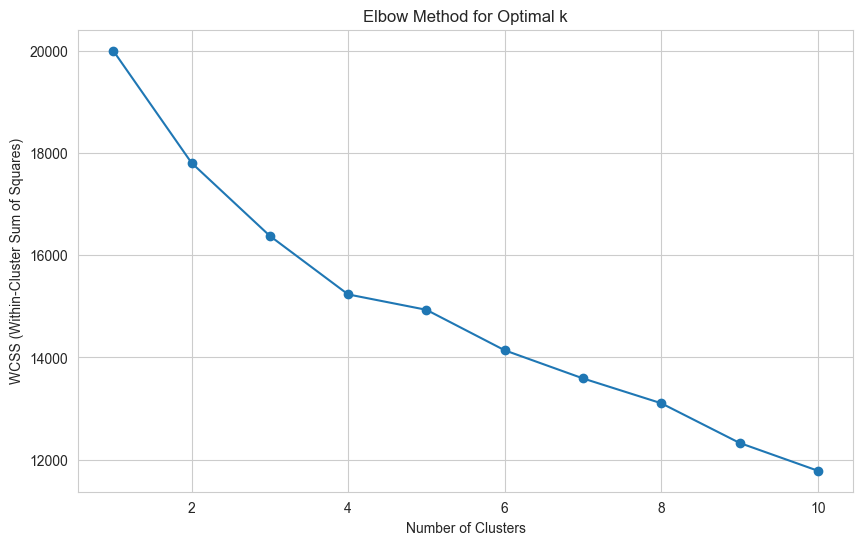

In [69]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.savefig('elbow_method.png')
plt.show()

In [70]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

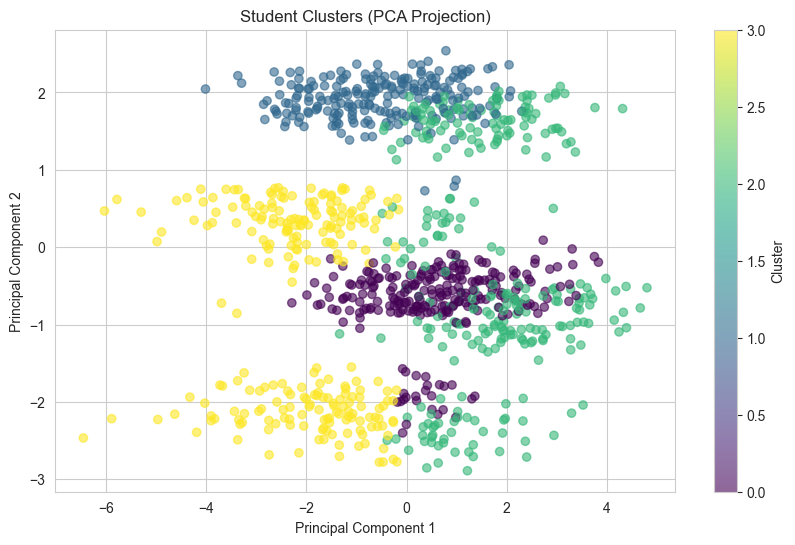

In [71]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
plt.scatter(principal_components[:, 0], principal_components[:, 1], 
            c=clusters, cmap='viridis', alpha=0.6)
plt.title('Student Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.savefig('student_clusters.png')
plt.show()


Cluster Profiles (Average Scores):
         math score  reading score  writing score
cluster                                          
0         67.521008      74.697479      74.226891
1         69.449074      64.333333      61.523148
2         73.579125      77.811448      78.346801
3         52.871486      57.771084      55.542169


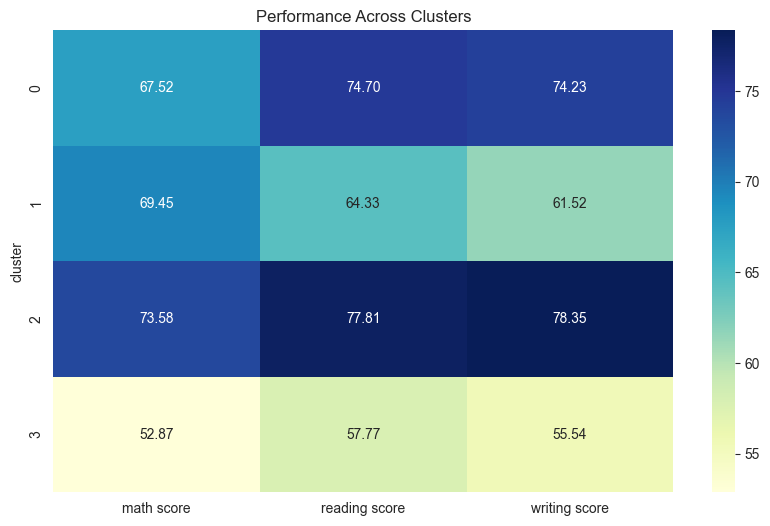

In [73]:
numeric_cols = ['math score', 'reading score', 'writing score']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')  # Convert to numeric if needed

# Group by 'cluster' and calculate mean for numeric columns only
cluster_profiles = df.groupby('cluster')[numeric_cols].mean()

# Display Cluster Profiles
print("\nCluster Profiles (Average Scores):")
print(cluster_profiles)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Performance Across Clusters')
plt.savefig('cluster_profiles.png')
plt.show()

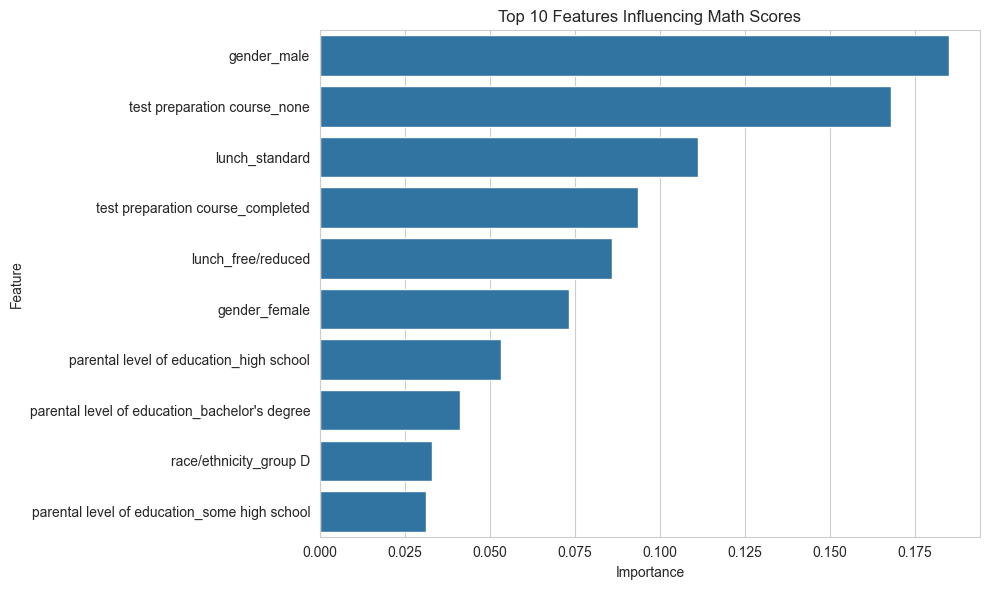

In [75]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,  
    'Importance': model.feature_importances_  
}).sort_values(by='Importance', ascending=False)  # Sort in descending order

# Plot Top 10 Features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features Influencing Math Scores')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()